$$ \LaTeX \text{ command declarations here.}
\newcommand{\R}{\mathbb{R}}
\renewcommand{\vec}[1]{\mathbf{#1}}
$$

In [1]:
# plotting
%matplotlib inline
from matplotlib import pyplot as plt;
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D

# scientific
import numpy as np;
from sklearn import mixture
import random
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn import metrics
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from pandas import DataFrame
from sympy import *

# math/misc
from __future__ import division
from time import time

# EECS 545:  Machine Learning
## Lecture 15:  Clustering, Mixture Models and EM
* Instructor:  **Jacob Abernethy**
* Date:  March 14, 2016


*Lecture Exposition*: Saket


## References

This lecture draws from following resources:

* Chapter 11: "Mixture Models and the EM algorithm" of *Machine Learning, A Probabilistic- Perspective* (Kevin P. Murphy), pp 337-348. 
* Lecture Notes, EECS 545 (Fall '15) by Dr. Clayton Scott, University of Michigan, Ann Arbor

## K-Means

### Clustering

Clustering is the problem of partitioning $\{ x_1 \dots x_N \}, x_i \in \R^d $ into disjoint subsets called **clusters** so that the points in the same cluster are more similar to each other than points in other clusters.

* A clustering is represented by *cluster map*, which is a function
$$ C: \{ 1,2, \dots, n \} \rightarrow \{ 1,2, \dots, K \} $$

where $K$ is the number of clusters.

## K-Means Criterion

The k-Means criterion is to choose C in order to minimize
$$ W(C) =  \sum_{l=1}^{K} \sum_{i:C(i) = l} ||x_i - \bar x_l ||^2  $$

where $\bar x_l = \frac{1}{n_l}\sum_{j:C(j)=l}x_j$ and $ n_l = \#\{ i: C(i) = l \}$

* Note: $K$ is assumed fixed and known.  


* $W(C)$ is sometimes known as within-class scatter.
* *Try it yourself*: Show that 
$$ W(C) = \frac{1}{2}\sum_{l=1}^{K} \sum_{i:C(i) = l} [ \frac{1}{n_l} \sum_{j:C(j)=l}||x_i - x_j||^2 ]$$


* The last term is a measure of average dissimilarity of a given point to other points in the same cluster. Most clustering algorithms can be viewed as optimizing some measure of (dis)similarity. 

## K-Means Algorithm

* Minimizing the k-Means criterion is a **combinatorial optimization problem** . The number of possible cluster maps is (Jain and Dubes, 1998)
$$ \begin{align}
&\frac{1}{K!} \sum_{l=1}^{K} (-1)^{K-l} {K \choose l} l^n \\
& = 34,105 \hspace{1em} if n=10, k=4\\
& \approx 10^{10} \hspace{2em} if n=19, k=4
\end{align} $$


* There is no known efficient search strategy for this space of functions. Therefore, we must resort to an iterative, sub-optimal algorithm.



Recall, we need to solve:
$$ C^* = \underset{C}{\arg\min} \sum_{l=1}^{K} \sum_{i:C(i)=l} || x_i - \bar x_l ||^2  $$ 

Notice that: 
$$
\begin{align}
\sum_i || x_i -m_l ||^2 
&= \sum_i || x_i - \bar x_l + \bar x_l - m_l ||^2 \\
&= p + q+ \sum_i ||\bar x_i - m_l ||^2
\end{align}$$
where $p = \sum_{i}||x_i - \bar x_l||^2$ and $q = 2\sum_i (x_i - \bar x_l)^T(\bar x_l - m_l) = 0 $ are independent of $m_l$ and the other term is minimized by $m_l = \bar x_l$

Hence,
$$ \bar x_l = \underset{m_l \in \R^d}{\arg\min} \sum_{i:C(i)=l}^{}|| x_i - m_l ||^2  $$

* Define 
$$ W(C, \{ m_l \}_{l=1}^k)  = \sum_{l=1}^{k} \sum_{i:C(i) = l} || x_i - m_l ||^2$$

* We have
$$ C^*  =  \underset{C, \{ m_l \}_{l=1}^k }{\arg\min} W(C, \{ m_l \}_{l=1}^k)  $$


* This suggests an iterative, *alternating* algorithm:
    * Given C, optimize $W(C, \{ m_l \}_{l=1}^k)$ wrt $\{ m_k \}$.
    * Given $\{ m_k \}$, optimize $W(C, \{ m_l \}_{l=1}^k)$ wrt C.

#### K-Means algorithm (Also called Lloyd's algorithm)

Initialize $ m_1 , \dots m_K \in \R^d $

Repeat:

$\hspace{2em}$ For i= 1 to n:

$\hspace{4em}$ $C(i) = \underset{l}{\arg\min}  ||x_i - m_l||^2 $ 

$\hspace{2em}$end

$\hspace{2em}$ For l= 1 to K:

$\hspace{4em}$ $m_l = \frac{1}{|\{ i:C(i) = l \} |} \sum_{i:C(i) = l} x_i$ 

$\hspace{2em}$end

Until clusters don't converge.

    

## Initialization

Highly dependent on initialization.

* Random: Choose $m_1, \dots, m_k$ to be randomly chosen data points.
    * It is common to run the algorithm with different initializations, and take the run with smallest $W(C)$.
    * Problems:
        * The number of iterations can be quite large in worst case.
        * The convergence value of $W(C)$ can be far from optimal case.


* K-Means++: efficient implementation, choose $m_1, \dots, m_k$ to be far apart.

### K-Means++
(Arthur and Vassilvitskii, 2007)

* Choose the first cluster center $m_1$ at random from among $X_1, \dots, X_n$
* For each $x \in \{X_1, \dots, X_n\}$, compute $D(x)$, the distance to nearest cluster center that has been selected.
* Choose one new data point $x$ at random as a new cluster center, with probability proportional to $D(x)^2$
* Repeat step 2 and step 3 until k cluster centers have been selected.
* Run k-means algorithm with these initial centers.

## Cluster Geometry

* Clusters are "nearest-neighbor" regions or **Voronoi cells** defined wrt cluster centers.
* Cluster boundaries are **piece-wise linear** .
* Clusters are convex sets.

<img src="voronoi.jpg" width=150px, height=150px align="middle">

* k-means will fail to identify true clusters if atleast one of them is *non-convex*.
* k-means can be **kernelized** to accomodate non-convex clusters.

### Examples of K-Means: Iris dataset

In [2]:
# Code adapted from scikit K-Means demo "K-means Clustering"

""" A demo of K-Means algorithm """
__author__      = "Saket Dewangan"


np.random.seed(5)

centers = [[1, 1], [-1, -1], [1, -1]]
iris = datasets.load_iris()
X = iris.data
y = iris.target

estimators = {'k_means_iris_3': KMeans(n_clusters=3),
              'k_means_iris_8': KMeans(n_clusters=8),
              'k_means_iris_bad_init': KMeans(n_clusters=3, n_init=1,
                                              init='random')}

def plotGroundTruth(X,y):
    # Plot the ground truth
    fig = plt.figure(1, figsize=(4, 3))
    plt.clf()
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

    plt.cla()

    for name, label in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:
        ax.text3D(X[y == label, 3].mean(), X[y == label, 0].mean() + 1.5, X[y == label, 2].mean(), name,
                    horizontalalignment='center', bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))

    plt.title('Ground Truth')    
    # Reorder the labels to have colors matching the cluster results
    y = np.choose(y, [1, 2, 0]).astype(np.float)
    ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=y)

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('Petal width')
    ax.set_ylabel('Sepal length')
    ax.set_zlabel('Petal length')
    plt.show()


def plotKMeans(X):
    fignum = 2
    l = ['#clusters = 8', '#clusters = 3', '#clusters = 3 with random initialization']
    for name, est in estimators.items():
        fig = plt.figure(fignum, figsize=(4, 3))
        plt.clf()
        ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

        plt.cla()
        est.fit(X)
        labels = est.labels_

        plt.title(l[fignum-2])
        ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=labels.astype(np.float))
        ax.w_xaxis.set_ticklabels([])
        ax.w_yaxis.set_ticklabels([])
        ax.w_zaxis.set_ticklabels([])
        ax.set_xlabel('Petal width')
        ax.set_ylabel('Sepal length')
        ax.set_zlabel('Petal length')
        fignum += 1


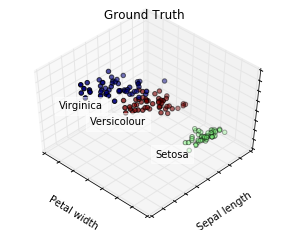

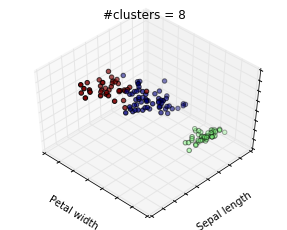

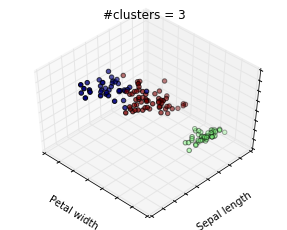

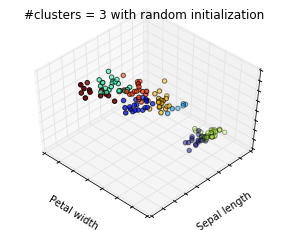

In [3]:
plotGroundTruth(X,y)
plotKMeans(X)

### Example of K-Means: Handwritten Digits

In [4]:
# Code adapted from scikit K-Means demo "A demo of K-Means clustering on the handwritten digits data"

""" A demo of K-Means algorithm """
__author__      = "Saket Dewangan"


# Set seed for random generator
np.random.seed(42)

# Load data
digits = load_digits()
data = scale(digits.data)

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

sample_size = 300


###############################################################################
# Visualize the results on PCA-reduced data

def plotKMeans():
    reduced_data = PCA(n_components=2).fit_transform(data)
    kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
    kmeans2 = KMeans(init='random', n_clusters=n_digits, n_init=10)
    kmeans.fit(reduced_data)
    kmeans2.fit(reduced_data)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
    W = kmeans2.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    W = W.reshape(xx.shape)
    
    
    #Plot K-Means++
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('K-means clustering :K-Means++')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()
    
    ## Plot K-Means Random
    plt.figure(2)
    plt.clf()
    plt.imshow(W, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans2.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('K-means clustering: Random initialization')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()
    

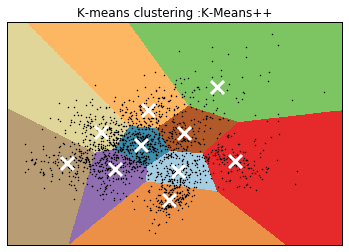

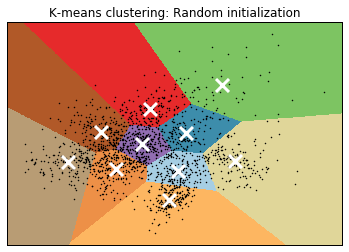

In [5]:
plotKMeans()

## Latent Variable Models

* We have seen graphical models to define joint probability distributions.
    * model dependence between two variables by adding an edge between them in the graph.
    

* Alternative approach is to assume that the observed variables are correlated because they arise from a **hidden common “cause”**.
    * Models with hidden variables are also known as latent variable models or LVMs.

## Mixture Models

The simplest form of LVM is when $z_i \in \{ 1 \dots K\}$, representing a discrete latent state. We use 
* discrete prior: $p(z_i) = Cat(\pi)^*$.
* Likelihood: $p(x_i|z_i = k) = p_k(x_i)$, where $p_k$ is the $k^{th}$ **base distribution** for the observations.


The overall model is a **mixture model**, since we are mixing together the $K$ base distributions:
$$ p(x_i|\theta)  = \sum_{k=1}^{K} \pi_k p_k(x_i|\theta) $$ 



*Recall:

Categorical Distribution $ x \sim Cat(\theta) \Rightarrow p(x=j|\theta) = \theta_j $ Refer to MLAPP (2.3.2) for further details. 

* ** Convex combination** of $p_k  s$, since it is a weighted sum.
* **Mixing weights** $\pi_k$: $0 \leq \pi_k \leq 1$ and $\sum_{k=1}^{K}\pi_k = 1$.

* Examples: (MLAPP, Table 11.1, pp. 339)

$$\begin{array}{lll}
Name                         & p(x_i|z_i)         & p(z_i)             \\ 
Mixture of Gaussians         & MVN                & Discrete           \\
Mixture of Multinomials      & Prod. Discrete     & Discrete           \\ 
Probabilistic PCA            & Product Gaussian   & Product Gaussian   \\
Probabilistic ICA            & Product Gaussian   & Product Laplacian  \\
Multinomial PCA              & Product Discrete   & Product Gaussian   \\ 
Latent Dirichlet Allocation  & Product Discrete   & Dirichlet          \\
BN20/QMR                     & Product Noisy-OR   & Product Bernoulli  \\ 
Sigmoid Belief Net           & Product Bernoulli  & Product Bernoulli  \\
\end{array}
$$

## Gaussian Mixture Models

* **GMMs** or sometimes called Mixture of Gaussians
* most widely used mixture models


* Each base distribution is multivariate Gaussian with mean $\mu_k$ and covariance matrix $\Sigma_k$


$$ p(x_i|\theta) = \sum_{k=1}^{K} \pi_k \mathcal{N}(x_i|\mu_k, \Sigma_k) $$




In [6]:
# Code adapted from Tiago Ramalho

def mixtures(x, y):
    g1 = mlab.bivariate_normal(x, y, 1.0, 1.0, -1, -1, -0.8)
    g2 = mlab.bivariate_normal(x, y, 1.5, 0.8, 1, 2, 0.6)
    return 0.6*g1+28.4*g2/(0.6+28.4)

def plot3DGaussian():
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    X = np.arange(-5, 5, 0.1)
    Y = np.arange(-5, 5, 0.1)
    X, Y = np.meshgrid(X, Y)
    Z = q(X, Y)
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.get_cmap('coolwarm'),
            linewidth=0, antialiased=True)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title('3D Gaussian Plot')
    #plt.savefig('3dgauss.png')

def sample():
    N = 10000
    s = 10
    r = np.zeros(2)
    p = q(r[0], r[1])
    #print p
    samples = []
    for i in xrange(N):
        rn = r + np.random.normal(size=2)
        pn = q(rn[0], rn[1])
        if pn >= p:
            p = pn
            r = rn
        else:
            u = np.random.rand()
            if u < pn/p:
                p = pn
                r = rn
        if i % s == 0:
            samples.append(r)

    samples = np.array(samples)
    plt.figure(2)
    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=1)

    dx = 0.01
    x = np.arange(np.min(samples), np.max(samples), dx)
    y = np.arange(np.min(samples), np.max(samples), dx)
    X, Y = np.meshgrid(x, y)
    Z = q(X, Y)
    CS = plt.contour(X, Y, Z, 10, alpha=0.5)
    plt.clabel(CS, inline=1, fontsize=10)
    plt.title('Samples')
    #plt.savefig("samples.png")
    return samples


NameError: name 'q' is not defined

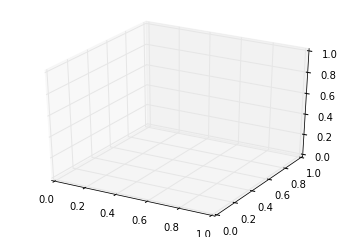

In [7]:
plot3DGaussian()
s = sample()

gmix = mixture.GMM(n_components=2, covariance_type='full')
gmix.fit(s)

plt.figure(2)
colors = ['r' if i==0 else 'g' for i in gmix.predict(s)]
ax = plt.gca()
ax.scatter(s[:,0], s[:,1], c=colors, alpha=0.8)
plt.title('Clusters')
#plt.savefig("class.png")

## Mixture of Multinomials

Suppose our data consists of D-dimensional bit vectors. In this case, an appropriate class-conditional density is a product of Bernoullis:

$$ p(x_i|z_i = k, \theta) = \prod_{j=1}^{D}Ber(x_{ij}|\mu_{jk}) = \prod_{j=1}^{D}\mu_{jk}^{x_{ij}}(1-\mu_{jk})^{1-x_{ij}} $$

where $\mu_{jk}$ is the probability that bit $j$ turns on in cluster $k$

### About latent variables

* **The latent variables do not need to mean anything**.
* Can just be used to make model more powerful or math easier.

* Example: mean and covariance of GMM:

$$ \mathbf{E}[x] = \sum_k\pi_k \mu_k $$

$$ cov[x] = \sum_k \pi_k [\Sigma_k + \mu_k \mu_k^T] - \mathbf{E}[x]\mathbf{E}[x]^T $$


where $\Sigma_k = diag(\mu_{jk}(1-\mu_{jk}))$.So although the component distributions are factorized, the joint distribution is not. Thus the mixture distribution can capture correlations between variables, unlike a single product-of-Bernoullis model.

## Mixture Models: Applications

* **Black-box** density model $p(x_i)$, useful for a variety of tasks, such as data compression, outlier detection, and creating generative classifiers, where we model each class-conditional density $p(x|y = c)$ by a mixture distribution.


* **Clustering** : fit the mixture model, and then compute $p(z_i = k|x_i , \theta)$, which represents the posterior probability that point $i$ belongs to cluster $k$.


## MIxture Models in Clustering 

* **Responsibility** of cluster $k$ for point $i$: posterior probability probability that point $i$ belongs to cluster $k$. 
    * Computed using Bayes' rule:
    
    $$ r_{ik} \triangleq p(z_i = k| x_i, \theta) =  \frac{p(z_i = k|\theta) p(x_i|z_i = k, \theta)}{\sum_{l=1}^{K}p(z_i = l|\theta) p(x_i|z_i = l, \theta)}$$
    

* This procedure is called **soft clustering**.
    * identical to generative classifier in computations.
    * difference in observability, we don't observe $z_i$ in mixture models.


#### Hard Clustering

* We can represent the amount of uncertainty in the cluster assignment by using $1 − max_k r_{ik}$ .

* Assuming this is small, it may be reasonable to compute a *hard clustering* using the MAP estimate, given by

$$ \begin{align}
z_i^*  
&= \underset{k}{\arg\max} \hspace{1em} r_{ik} \\
&= \underset{k}{\arg\max} \hspace{1em} log p(x_i|z_i = k, \theta) + log p(z_i = k|\theta) 
\end{align}$$

## Parameter Estimation

#### How to learn the values of parameters

* In Lecture 13, we showed that when we have complete data and a factored prior, the posterior over the parameters also factorizes, making computation very simple.

* This method fails when we have hidden variable (and/or missing data)

* In LVMs, we have hidden variables $z_i$, hence the parameters are no longer independent 
    * $\Rightarrow$ Posterior does not factorize and hence, it is very difficult to compute!!

### 1. Unidentifiability

* Main problem with computing $p(\theta|\mathcal{D})$ is that posterior may have multiple modes.

* Consider a GMM. 
    * If all $z_i$ are observed, posterior is unimodal:
$$ p(\theta|\mathcal{D}) = Dir (\pi| \mathcal{D}) \prod_{k=1}^{K} NIW(\mu_k, \Sigma_k| \mathcal{D}) $$

    * Easy to find globally optimal MAP estimate and hence, globally optimal MLE.
    
    * But if $z_i$s are hidden, for each possible way of filling in $Z_i$s, there is a different unimodal likelihood.
    
    * Hence, marginalizing over all $z_i$s gives a multi-modal posterior for $p(\theta|\mathcal{D})$
    

* We say that parameters are not **identifiable**, when there is not a unique MLE (and hence no unique MAP, assuming prior does not rule out certain labelings).


* How many modes are there?
    * *Hard* to answer.
    * Total $K!$ possible, but several peaks might get merged.
    * Finding optimal MLE is NP hard (Aloise et al. 2009), hence there can be an exponential number.

### 2. Computing MAP estimate is non-convex

* Consider log-likelihood for an LVM:
$$ log (p(\mathcal{D}|\theta)  = \sum_i log [\sum_{z_i} p(x_i, z_i|\theta)] $$

* Hard to maximize because of sum inside log-term.

* Now suppose $p(z_i, x_i|\theta)$ is in exponential family, which can be written as (Lecture 13):
$$ p(z_i, x_i|\theta) = \frac{1}{Z(\theta)}exp(\theta^T \phi(x,z)) $$

* Complete data log likehood:
$$ l_c(\theta) = \sum_i log p(x_i, z_i|\theta) = \theta^T(\sum_i \phi(x_i, z_i)) - N Z(\theta) $$


* The first term is linear in $\theta$
* $Z(\theta)$ is convex in $\theta$ ((Boyd and Vandenberghe 2004)
* So, overall term becomes concave due to minus sign.
* Hence, a unique maximum exists.

#### The curious case of missing data

* Observed data log likelihood:
$$ l(\theta) = \sum_i log \sum_{z_i} p(x_i, z_i|\theta) = \sum_i log [\sum_{z_i} exp(\theta^T \phi(z_i, x_i))] - N log Z(\theta) $$

* log-sum-exp function is convex (Boyd and Vandenberghe 2004)
* $Z(\theta)$ is convex.
* However, the difference is not necessarily convex.
* Hence, only local optima exist.

## Model selection in k-means

**How should K be chosen**?

* Let $\hat C_k$ denote the output of k-means.
* Plot $W(\hat C_k)$ as a function of k.

* Basic idea: if $K^*$ is ideal cluster number, then
    * $k < K^*: W(\hat C_{k+1}) -  W(\hat C_{k})$ is relatively large (Variance explained is large).
    * $k \geq K^*: W(\hat C_{k+1}) -  W(\hat C_{k})$ is relatively small (Variance explained is small).
    
* This suggests choosing $K$ near the "elbow" of the curve.


(image from Wikipedia: https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set)
<img src="elbow.JPG" width=300px, height=300px align="middle">

The "elbow" is indicated by the red circle. The number of clusters chosen should therefore be 4.


* A more systematic method was developed by Kulis and Jordan (2007)

* Optimize the following function wrt both C and K:
$$ \sum_{l=1}^{K} \sum_{i:C(i) = l} ||x_i - \bar x_l||^2 + \lambda k $$

where $\lambda$ is a tradeoff parameter.

* This is derived from a non-parametric Bayesian perspective.

* Can be optimized sub-optimally by variant of k-means algorithm.